In [1]:
import csv
import json
import requests
import pprint

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans

%matplotlib inline

pd.set_option('display.max_columns', None)
data = pd.read_csv('data/Second_half_2019_over0.csv', header=[0,1], index_col=0)
# data1 = pd.read_csv('data/sortby_MAC_Time_2019.csv', header=[0,1], index_col=0)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 건물 각 층의 AP 구하기

In [2]:
def Session_number(building_floor):
    dic = {}
    connection = data[data[('AP','Map Location')].str.contains(building_floor)]    
    
    for idx, val in connection.iterrows():
        curstr = str(val[ ('AP', 'Name') ])
        if curstr in dic:
            dic[curstr] = dic[curstr]+1
        else:
            dic[curstr] = 1
    
    res = sorted(dic.items(), key=lambda x: x[1], reverse=True )        

    return res

# 건물선정하기

사용이 가장 많은 건물 중에서 스루풋이 가장 낮은 건물

# 1. 데이터 정리

## Session Duration 합치기

In [4]:
seconds = data[('Session Duration', 'days')]*24*60*60 + data[('Session Duration', 'hours')]*60*60 + data[('Session Duration', 'minutes')]*60 + data[('Session Duration', 'seconds')]
data[('Sum of Session Duration', 'seconds')] = seconds

## Avg. Session Throughput (Kbps) 의 string -> float 

In [18]:
# 10,000
con = data[('Utilization','Avg. Session Throughput (Kbps)')].str.contains(',')
comma_data = data[('Utilization','Avg. Session Throughput (Kbps)')][con]

for index,c_d in zip(comma_data.index,comma_data):
    comma_pos = c_d.find(',')
    data[('Utilization','Avg. Session Throughput (Kbps)')][index] = c_d[:comma_pos] + c_d[comma_pos+1:]


In [31]:
# <0.1
in_str = data[('Utilization','Avg. Session Throughput (Kbps)')]=='<0.1'
data.loc[in_str,('Utilization','Avg. Session Throughput (Kbps)')] = '0.05'

In [32]:
(data[('Utilization','Avg. Session Throughput (Kbps)')]=='<0.1').sum()

0

In [33]:
data[('Utilization','Avg. Session Throughput (Kbps)')] = data[('Utilization','Avg. Session Throughput (Kbps)')].astype(float)


## ('AP','Building Num') 건물 넘버 칼럼 추가

In [47]:
# 사용이 가장 많은 건물 중에서 스루풋이 가장 낮은 건물
# Session Duration에 차이가 있는 건물
data[('AP','Building Num')] = '0'
location = data[('AP','Map Location')]
dic = {}
idx=[]
num=[]
for index, loc_data in zip(location.index,location):
    
    line = loc_data.split(')')[0]
    loc_num = line[-3:]
    
    idx.append(index)
    num.append(loc_num)

dic['idx'] = idx
dic['num'] = num

In [48]:
building = pd.DataFrame(dic)
building = building.set_index("idx")
data[('AP','Building Num')] = building['num']

In [49]:
# data.to_csv('data/sep_building,throuput,hour.csv')

# 2. 어떤건물로 선정할지

## 비교할 칼럼만 가져오기

- Sum of Session Duration
- Avg. Session Throughput (Kbps)
- Bytes Sent, Bytes Received
- Utilization
- RSSI (dBm)
- Utilization
- SNR (dB)

In [50]:
tocampare_col = data[[('Sum of Session Duration', 'seconds'), ('Utilization','Avg. Session Throughput (Kbps)'), ('Utilization', 'Bytes Sent'), ('Utilization','Bytes Received'), ('Utilization','RSSI (dBm)'),('Utilization','SNR (dB)')]]


In [51]:
tocampare_col.corr()

Sum of Session Duration  \
0                                                                      seconds   
                        0                                                        
Sum of Session Duration seconds                                       1.000000   
Utilization             Avg. Session Throughput (Kbps)                0.008214   
                        Bytes Sent                                    0.025910   
                        Bytes Received                                0.112558   
                        RSSI (dBm)                                    0.072305   
                        SNR (dB)                                      0.073821   

                                                                          Utilization  \
0                                                      Avg. Session Throughput (Kbps)   
                        0                                                               
Sum of Session Duration seconds                                              0.008214   
Utilization             Avg. Session Throughput (Kbps)                       1.000000   
                        Bytes Sent                                           0.245849   
                        Bytes Received                                       0.470013   
                        RSSI (dBm)                                           0.054624   
                        SNR (dB)                                             0.055488   

                                                                   \
0                                                      Bytes Sent   
                        0                                           
Sum of Session Duration seconds                          0.025910   
Utilization             Avg. Session Throughput (Kbps)   0.245849   
                        Bytes Sent                       1.000000   
                        Bytes Received                   0.160727   
                        RSSI (dBm)                       0.013372   
                        SNR (dB)                         0.014112   

                                                                       \
0                                                      Bytes Received   
                        0                                               
Sum of Session Duration seconds                              0.112558   
Utilization             Avg. Session Throughput (Kbps)       0.470013   
                        Bytes Sent                           0.160727   
                        Bytes Received                       1.000000   
                        RSSI (dBm)                           0.064163   
                        SNR (dB)                             0.065684   

                                                                             
0                                                      RSSI (dBm)  SNR (dB)  
                        0                                                    
Sum of Session Duration seconds                          0.072305  0.073821  
Utilization             Avg. Session Throughput (Kbps)   0.054624  0.055488  
                        Bytes Sent                       0.013372  0.014112  
                        Bytes Received                   0.064163  0.065684  
                        RSSI (dBm)                       1.000000  0.852340  
                        SNR (dB)                         0.852340  1.000000

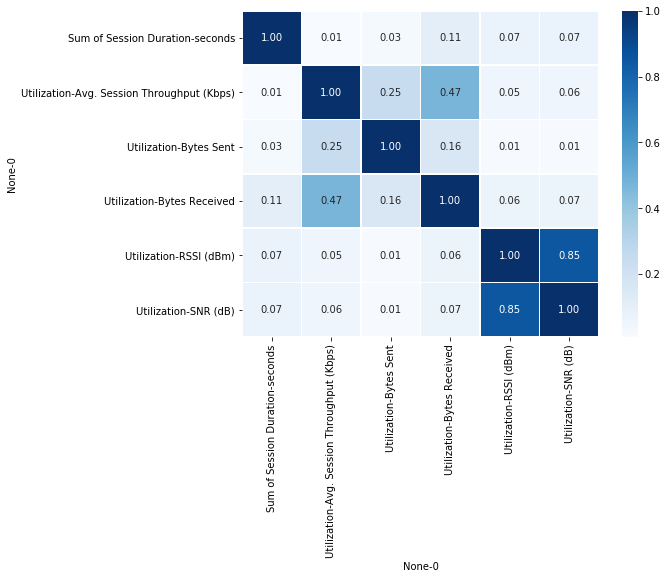

In [52]:
plt.figure(figsize=(8,6))
sns.heatmap(data = tocampare_col.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

### -> 스루풋이 가장 낮은 건물들로 건물 선정 할 것

# 3. 건물 선정하기

# 세션수많은 곳 = 사용자가 많은 곳

### 건물별로 세션개수 몇개인지 칼럼 추가

In [53]:
# 사용자가 가장 많은 건물 중에서 스루풋이 가장 낮은 건물
# Session Duration에 차이가 있는 건물

# 빌딩마다 몇명의 사용자가 있는지
data[('Session count', 'num')] = 0
building_num = data[('AP','Building Num')].unique()

for num in building_num:
    target_building = (data[('AP','Building Num')] == num)
    #세션수의 개수
    l = len(data[target_building])
    data[('Session count', 'num')][target_building] = l
#     print(len(building_num)

#사용자가 100000명 이상인 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


### 건물별로 세션개수 순으로 정렬

In [54]:
desc_session = data[('Session count','num')].groupby(data[('AP','Building Num')]).describe()
desc_session = desc_session.sort_values(by=['count'], axis=0)

In [55]:
desc_session

,count,mean,std,min,25%,50%,75%,max
"(AP, Building Num)",,,,,,,,
o1F,256.0,256.0,0.0,256.0,256.0,256.0,256.0,256.0
702,256.0,256.0,0.0,256.0,256.0,256.0,256.0,256.0
109,1304.0,1304.0,0.0,1304.0,1304.0,1304.0,1304.0,1304.0
110,1357.0,1357.0,0.0,1357.0,1357.0,1357.0,1357.0,1357.0
102,1502.0,1502.0,0.0,1502.0,1502.0,1502.0,1502.0,1502.0
...,...,...,...,...,...,...,...,...
210,116348.0,116348.0,0.0,116348.0,116348.0,116348.0,116348.0,116348.0
306,123558.0,123558.0,0.0,123558.0,123558.0,123558.0,123558.0,123558.0
401,211126.0,211126.0,0.0,211126.0,211126.0,211126.0,211126.0,211126.0


## 세션개수가 만개 이상인 것들 가져오기 

In [98]:
# top40_building_name_ss = desc_session[-40:].index
top40_building_name_ss = desc_session[desc_session['count']>10000].index

In [99]:
top40_building_name_ss

Index(['419', '707', '501', '608', '415', '714', '309', '412', '209', '706',
       '208', '502', '108', '705', '414', '709', '307', '506', '211', '411',
       '311', '701', '308', '314', '418', '406', '602', '607', '207', '312',
       '606', '313', '206', '417', '601', '416', '510', '105', '201', '303',
       '708', '107', '508', '310', '420', '704', '422', '421', '609', '405',
       '205', '514', '515', '210', '306', '401', 'OOR', '516'],
      dtype='object', name=('AP', 'Building Num'))

In [100]:
conditiontop40_ss = data[('AP','Building Num')].isin(top40_building_name_ss)

In [101]:
session_count_top40 = data[conditiontop40_ss]

## 스루풋의 편차로 정렬하기

In [102]:
desc = session_count_top40[('Utilization','Avg. Session Throughput (Kbps)')].groupby(session_count_top40[('AP','Building Num')]).describe()


In [103]:
desc.sort_values(by=['std'], axis=0)

,count,mean,std,min,25%,50%,75%,max
"(AP, Building Num)",,,,,,,,
307,24260.0,75.693704,355.192932,0.05,0.7,3.20,28.900,17782.7
506,25376.0,95.613123,422.694127,0.05,0.8,5.00,50.300,26506.8
210,116348.0,100.653511,437.512939,0.05,1.0,6.90,57.400,35159.0
606,51598.0,103.238111,438.318849,0.05,0.7,3.70,44.000,43336.2
OOR,221640.0,74.307307,441.857806,0.05,0.7,2.60,20.000,76627.1
707,11535.0,117.854144,479.192868,0.05,0.9,5.60,68.800,21073.3
314,35914.0,112.723176,492.170248,0.05,0.9,5.20,55.300,22419.1
208,20511.0,94.976242,495.312618,0.05,0.7,3.10,33.900,22135.2
415,13258.0,136.283414,505.577190,0.05,0.6,3.20,54.300,23494.1


# mac이 많은 곳을 사용자가 많은 곳으로

### 건물별로 세션개수 몇개인지 칼럼 추가

In [104]:
# 사용자가 가장 많은 건물 중에서 스루풋이 가장 낮은 건물
# Session Duration에 차이가 있는 건물

# 빌딩마다 몇명의 사용자가 있는지
data[('MAC count', 'num')] = 0
building_num = data[('AP','Building Num')].unique()

for num in building_num:
    target_building = data[('AP','Building Num')] == num
    l = len(data[target_building][('Client','MAC Address')].unique())
    data[('MAC count', 'num')][target_building] = l
#     print(len(building_num)

#사용자가 100000명 이상인 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [105]:
# data.drop([('Client','MAC_EP')], axis=1, inplace=True)
desc_mac = data[('MAC count','num')].groupby(data[('AP','Building Num')]).describe()
desc_mac = desc_mac.sort_values(by=['count'], axis=0)

In [106]:
desc_mac

,count,mean,std,min,25%,50%,75%,max
"(AP, Building Num)",,,,,,,,
o1F,256.0,225.0,0.0,225.0,225.0,225.0,225.0,225.0
702,256.0,135.0,0.0,135.0,135.0,135.0,135.0,135.0
109,1304.0,869.0,0.0,869.0,869.0,869.0,869.0,869.0
110,1357.0,143.0,0.0,143.0,143.0,143.0,143.0,143.0
102,1502.0,346.0,0.0,346.0,346.0,346.0,346.0,346.0
...,...,...,...,...,...,...,...,...
210,116348.0,7900.0,0.0,7900.0,7900.0,7900.0,7900.0,7900.0
306,123558.0,10358.0,0.0,10358.0,10358.0,10358.0,10358.0,10358.0
401,211126.0,6402.0,0.0,6402.0,6402.0,6402.0,6402.0,6402.0


In [75]:
len(data[('AP','Building Num')].unique())

81

## 맥 수가 만개 이상인 것들 가져오기 

In [107]:
# top40_building_name_ap = desc_mac[-40:].index
top40_building_name_ap = desc_mac[desc_mac['count']>10000].index

In [108]:
top40_building_name_ap

Index(['419', '707', '501', '608', '415', '714', '309', '412', '209', '706',
       '208', '502', '108', '705', '414', '709', '307', '506', '211', '411',
       '311', '701', '308', '314', '418', '406', '602', '607', '207', '312',
       '606', '313', '206', '417', '601', '416', '510', '105', '201', '303',
       '708', '107', '508', '310', '420', '704', '422', '421', '609', '405',
       '205', '514', '515', '210', '306', '401', 'OOR', '516'],
      dtype='object', name=('AP', 'Building Num'))

In [109]:
conditiontop40 = data[('AP','Building Num')].isin(top40_building_name_ap)

In [110]:
mac_count_top40 = data[conditiontop40]

In [111]:
desc = mac_count_top40[('Utilization','Avg. Session Throughput (Kbps)')].groupby(mac_count_top40[('AP','Building Num')]).describe()


## 스루풋의 편차로 정렬하기

In [112]:
desc.sort_values(by=['std'], axis=0)

,count,mean,std,min,25%,50%,75%,max
"(AP, Building Num)",,,,,,,,
307,24260.0,75.693704,355.192932,0.05,0.7,3.20,28.900,17782.7
506,25376.0,95.613123,422.694127,0.05,0.8,5.00,50.300,26506.8
210,116348.0,100.653511,437.512939,0.05,1.0,6.90,57.400,35159.0
606,51598.0,103.238111,438.318849,0.05,0.7,3.70,44.000,43336.2
OOR,221640.0,74.307307,441.857806,0.05,0.7,2.60,20.000,76627.1
707,11535.0,117.854144,479.192868,0.05,0.9,5.60,68.800,21073.3
314,35914.0,112.723176,492.170248,0.05,0.9,5.20,55.300,22419.1
208,20511.0,94.976242,495.312618,0.05,0.7,3.10,33.900,22135.2
415,13258.0,136.283414,505.577190,0.05,0.6,3.20,54.300,23494.1


# 끝

# 1

In [113]:
# data[data[('AP','Building Num')] == 'New'][('AP','Name')].unique()
data[data[('AP','Building Num')] == '414'][('AP','Map Location')].unique()

array(['Pusan > GiGoo (414) > GiGoo B1', 'Pusan > GiGoo (414) > GiGoo 2F',
       'Pusan > GiGoo (414) > GiGoo 1F', 'Pusan > GiGoo (414) > GiGoo 3F',
       'Pusan > GiGoo (414) > GiGoo 4F'], dtype=object)

In [115]:
# worst = data[data[('AP','Building Num')] == '414']
# worst[('AP','Map Location')]
for i in range(0,4):
    l = Session_number('GiGoo ' + str(i+1))
    print(str(i+1)+'층 : ', end='')
    print(l)


1층 : [('11S-414-1-1', 1615), ('16AP-414-1-2', 834)]
2층 : [('SAP-92.241', 6156), ('16AP-414-2-1', 567)]
3층 : [('SAP-92.242', 5223), ('16AP-414-3-3', 1350), ('16AP-414-3-1', 676)]
4층 : [('16AP-414-4-1', 851)]


# 2

In [116]:
data[data[('AP','Building Num')] == '709'][('AP','Map Location')].unique()

array(['Pusan > KwaHakGiSul (709) > KwaHakGiSul4F',
       'Pusan > KwaHakGiSul (709) > KwaHakGiSul2F',
       'Pusan > KwaHakGiSul (709) > KwaHakGiSul3F'], dtype=object)

In [120]:
for i in range(0,4):
    l = Session_number('KwaHakGiSul' + str(i+1))
    print(str(i+1)+'층 : ', end='')
    print(l)
    

1층 : []
2층 : [('SAP-122.245', 7407), ('SAP-122.244', 3570)]
3층 : [('SAP-122.246', 4774), ('SAP-122.247', 3001)]
4층 : [('SAP-122.249', 2305), ('SAP-122.248', 1529)]


# 3

In [121]:
data[data[('AP','Building Num')] == '418'][('AP','Map Location')].unique()

array(['Pusan > KyoSu2 (418) > Kyosu2 1F',
       'Pusan > KyoSu2 (418) > Kyosu2 3F',
       'Pusan > KyoSu2 (418) > Kyosu2 4F',
       'Pusan > KyoSu2 (418) > Kyosu2 2F'], dtype=object)

In [122]:
for i in range(0,4):
    l = Session_number('Kyosu2 ' + str(i+1))
    print(str(i+1)+'층 : ', end='')
    print(l)

1층 : [('AP-418-1-3', 4607), ('16K-418-1-2', 1398), ('16K-418-1-1', 1350)]
2층 : [('16K-418-2-1', 3845), ('11S-418-2-4', 3084), ('16K-418-2-2', 1280), ('16K-418-2-3', 1074)]
3층 : [('11S-418-3-5', 2970), ('16K-418-3-3', 1815), ('11S-418-3-4', 1542), ('16K-418-3-1', 1002), ('16K-418-3-2', 598)]
4층 : [('16K-418-4-1', 5437), ('11S-418-4-4', 4117), ('11S-418-4-5', 3330), ('16K-418-4-3', 1557), ('16K-418-4-2', 999)]


# 4

In [127]:
data[data[('AP','Building Num')] == '514'][('AP','Map Location')].unique()

array(['Pusan > KyungYoung (514) > SangHak 1F',
       'Pusan > KyungYoung (514) > SangHak 3F',
       'Pusan > KyungYoung (514) > SangHak 2F',
       'Pusan > KyungYoung (514) > SangHak 4F'], dtype=object)

In [128]:
for i in range(0,4):
    l = Session_number('SangHak ' + str(i+1))
    print(str(i+1)+'층 : ', end='')
    print(l)

1층 : [('11S-514-1-6', 9387), ('SAP-82.235', 5247), ('16K-514-1-4', 4519), ('16K-514-1-2', 2775), ('16K-514-1-3', 1918), ('16K-514-1-1', 1633), ('16K-514-1-5', 383)]
2층 : [('SAP-82.236', 7525), ('SAP-80.245', 4661), ('16K-514-2-4', 4448), ('16K-514-2-2', 3196), ('16K-514-2-6', 1849), ('16K-514-2-5', 1819), ('16K-514-2-3', 1427), ('16K-514-2-1', 446)]
3층 : [('11S-514-3-4', 6300), ('SAP-81.252', 5701), ('16K-514-3-3', 3051), ('SAP-81.253', 2317), ('16K-514-3-2', 903), ('16K-514-3-1', 650)]
4층 : [('AP-514-4-6', 8943), ('AP-514-4-5', 8466), ('16K-514-4-3', 4410), ('16K-514-4-1', 1772), ('16K-514-4-4', 1294), ('16K-514-4-2', 1175)]


# 5

In [129]:
data[data[('AP','Building Num')] == '609'][('AP','Map Location')].unique()

array(['Pusan > BeobHak (609) > BeobHak2F',
       'Pusan > BeobHak (609) > BeobHak1F',
       'Pusan > BeobHak (609) > BeobHak3F',
       'Pusan > BeobHak (609) > BeobHak4F'], dtype=object)

In [137]:
for i in range(0,4):
    l = Session_number('BeobHak' + str(i+1))
    print(str(i+1)+'층 : ', end='')
    print(l)

1층 : [('16K-609-1-6', 3216), ('16K-609-1-4', 1734), ('16K-609-1-1', 1063), ('16K-609-1-3', 759), ('16K-609-1-2', 578), ('16K-609-1-5', 355)]
2층 : [('SAP-86.240', 8549), ('16K-609-2-1', 4178), ('16K-609-2-2', 3428), ('16K-609-2-3', 2261), ('SAP-157.235', 1997), ('SAP-157.236', 1309)]
3층 : [('16K-609-3-2', 4494), ('16K-609-3-3', 1727), ('11S-609-3-6', 1531), ('16K-609-3-1', 983), ('16K-609-3-4', 844), ('16K-609-3-5', 680), ('11S-609-3-7', 593)]
4층 : [('16K-609-4-5', 6293), ('16K-609-4-3', 6079), ('16K-609-4-4', 5981), ('16K-609-4-8', 5589), ('16K-609-4-7', 5487), ('16AP-609-4-10', 4360), ('16K-609-4-6', 3494), ('16AP-609-4-9', 3490), ('16K-609-4-2', 241), ('16K-609-4-1', 237)]
